In [1]:
import mikeio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pynori.plotter import scatter
from pyplume.plotting.matplotlib_shell import subplots, dhi_colors

# Load model results

In [2]:
def depth_corrector(coordinates, correction_value, change_sign=False):
    coordinates[:, 2] = coordinates[:, 2] + correction_value
    if change_sign:
        coordinates[:, 2] = -coordinates[:, 2]
    return coordinates

In [3]:
def get_layers(coordinates):
    layers = np.unique(coordinates[:, 2])
    return layers

In [4]:
def find_layer_coordinates(coordinates, layers, layer_no):
    layer = layers[layer_no]
    layer_coordinates = coordinates[coordinates[:, 2] == layer]
    layer_indices = np.where(coordinates[:, 2] == layer)[0]
    return layer_indices, layer_coordinates

In [5]:
def find_closest_layer_index(layers, observation_depth):
    if observation_depth < layers[0]:
        return np.nan
    if observation_depth > layers[-1]:
        return np.nan
    return np.argmin(np.abs(layers - observation_depth))

In [6]:
def find_values_within_radius(layer_values, layer_coordinates, observation_coordinates, radius):
    distances = np.sqrt((layer_coordinates[:, 0] - observation_coordinates[0]) ** 2 + (layer_coordinates[:, 1] - observation_coordinates[1]) ** 2)
    return layer_values[distances < radius]

In [7]:
def get_plotting_data(X, Y):
    unique_Y = np.unique(Y)
    unique_X = []
    for i, y in enumerate(unique_Y):
        unique_X.append(np.max(X[Y == y]))
    unique_X = np.array(unique_X)
    data = np.vstack((unique_X, unique_Y)).T
    data = data[data[:, 1].argsort()]
    return data

In [8]:
### pr2 test
#model_fname = r"\\USDEN1-STOR.DHI.DK\Projects\41806287\Models\Midwater\05_runs\rev3\midwater_plume_pr2test.m3fm - Result Files\MT_3D_items\Total_SSC.dfsu"
#depth_correction = -1225
#test_name = "pr2"
### str test
model_fname = r"\\USDEN1-STOR.DHI.DK\Projects\41806287\Models\Midwater\05_runs\rev3\midwater_plume_str_test.m3fm - Result Files\MT_3D_items\Total SSC.dfsu"
depth_correction = -1225
test_name = "str"

### ROV Near Field
ROV = pd.read_csv(r"\\USDEN1-STOR.DHI.DK\Projects\41806287\41806287 NORI-D Data\Workflow Execution\ROV CTD Calibration\observations\ROV\near field\01_near_field_ROV_CTD.csv", index_col=0, parse_dates=True)
ROV_loc = "Near Field"
### ROV Far Field
#ROV = pd.read_csv(r"\\USDEN1-STOR.DHI.DK\Projects\41806287\41806287 NORI-D Data\Workflow Execution\ROV CTD Calibration\observations\ROV\far field\01_far_field_ROV_CTD.csv", index_col=0, parse_dates=True)
#ROV_loc = "Far Field"


### pr1, Near Field
#xlim = 110
### pr2, Near Field
#xlim = 80
### pr2, Far Field
#xlim = 10
### str, Near Field
xlim = 100
### str, Far Field
#xlim = 10

mask = (ROV["AREA"] == "MIDWATER")
ROV = ROV[mask]
radii = [25, 50, 75, 100]

change_sign = True
model_unit_conversion = 1000

dfsu = mikeio.read(model_fname)[0]

100%|██████████| 6711/6711 [10:21<00:00, 10.80it/s]


In [ ]:
element_coordinates = dfsu.geometry.element_coordinates.copy()
element_coordinates = depth_corrector(element_coordinates, depth_correction, change_sign)
layers = get_layers(element_coordinates)
values = dfsu.values.copy()
times = dfsu.time.copy()
if test_name == "str":
    times = times + pd.Timedelta(seconds=1)
print("Model loaded!")
ROV_time = ROV.index.copy()
time_intersection = times.intersection(ROV_time)
ROV = ROV.loc[time_intersection]
ROV_time = ROV.index.copy()

ROV_x = ROV["ROV Easting"].to_numpy().copy()
ROV_y = ROV["ROV Northing"].to_numpy().copy()
ROV_z = ROV["ROV Depth"].to_numpy().copy()
ROV_coordinates = np.vstack((ROV_x, ROV_y, ROV_z)).T
ROV_values = ROV["SSC (mg/L)"].to_numpy().copy()
print("ROV loaded!")

Outputs calculated for radius 25!
Outputs calculated for radius 50!
Outputs calculated for radius 75!
Outputs calculated for radius 100!


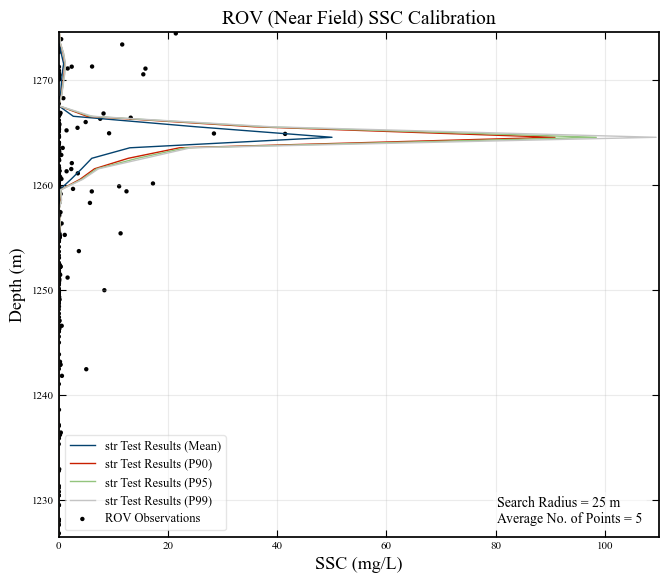

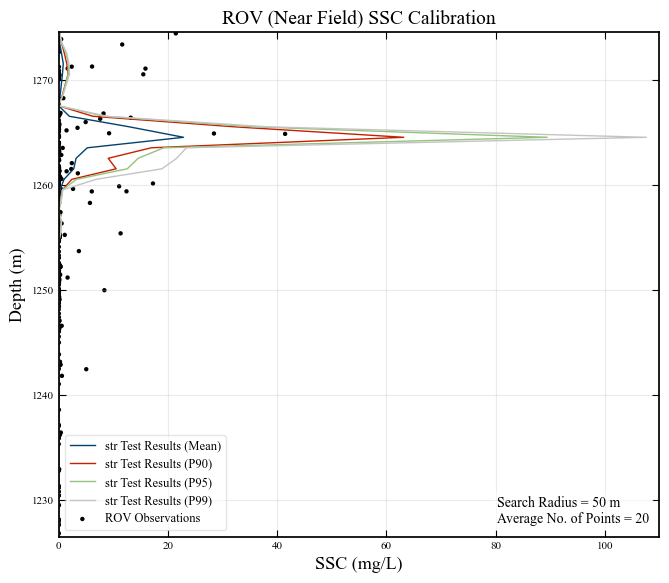

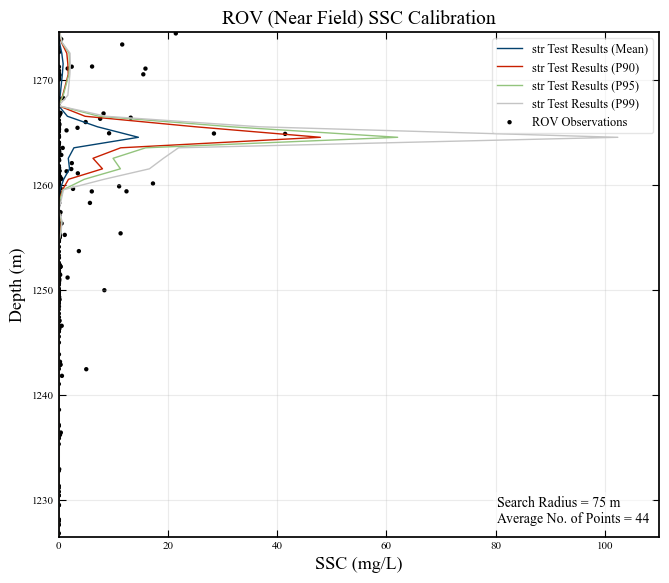

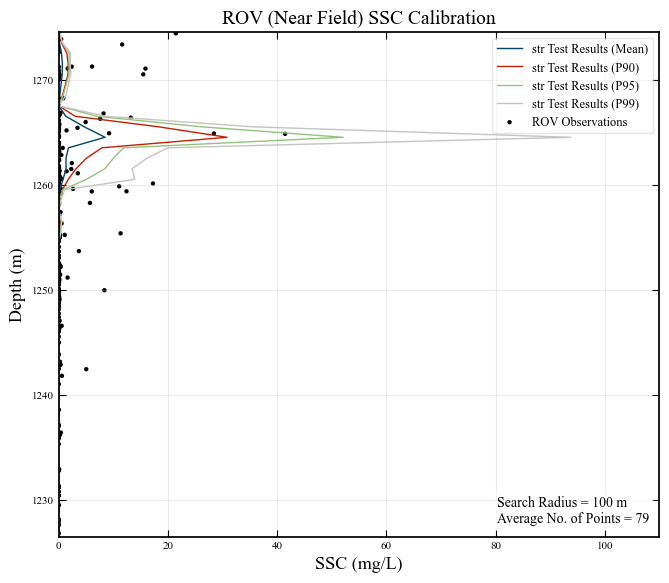

In [29]:

for radius in radii:
    outputs = {"Depth": [], "Min": [], "P1": [], "P5": [], "P10": [], "Mean": [], "P90": [], "P95": [], "P99": [], "Max": []}
    n_points = []
    for i, time in enumerate(time_intersection):
        time_index = np.where(times == time)[0][0]
        ROV_time_index = np.where(ROV_time == time)[0][0]
        ROV_depth = ROV_coordinates[ROV_time_index, 2]
        ROV_xy = ROV_coordinates[ROV_time_index, :2]
        layer_index = find_closest_layer_index(layers, ROV_depth)
        if np.isnan(layer_index):
            continue
        layer_indices, layer_coordinates = find_layer_coordinates(element_coordinates, layers, layer_index)
        layer_values = values[time_index, layer_indices]
        output_values = find_values_within_radius(layer_values, layer_coordinates, ROV_xy, radius)
        if len(output_values) == 0:
            continue
        outputs["Depth"].append(layers[layer_index])
        outputs["Min"].append(np.min(output_values))
        outputs["P1"].append(np.percentile(output_values, 1))
        outputs["P5"].append(np.percentile(output_values, 5))
        outputs["P10"].append(np.percentile(output_values, 10))
        outputs["Mean"].append(np.mean(output_values))
        outputs["P90"].append(np.percentile(output_values, 90))
        outputs["P95"].append(np.percentile(output_values, 95))
        outputs["P99"].append(np.percentile(output_values, 99))
        outputs["Max"].append(np.max(output_values))
        
        n_points.append(len(output_values))
    print(f"Outputs calculated for radius {radius}!")
    outputs = pd.DataFrame(outputs)
    outputs.set_index("Depth", inplace=True)
    outputs = outputs * model_unit_conversion
    
    colors = [dhi_colors.blue1, dhi_colors.red1, dhi_colors.green1, dhi_colors.gray1]
    fig, ax = subplots()
    for col in ["Mean", "P90", "P95", "P99"]:
        data = get_plotting_data(outputs[col].to_numpy().copy(), outputs.index.to_numpy().copy())
        ax.plot(data[:, 0], data[:, 1], label=f"{test_name} Test Results ({col})", linewidth=1, color=colors.pop(0))


    mask = (ROV_coordinates[:, 2] > np.min(layers)) & (ROV_coordinates[:, 2] < np.max(layers))
    fig, ax = scatter(ROV_values[mask], ROV_coordinates[mask, 2], np.arange(0, 71, 5), np.arange(1200, 1251, 2), fig=fig, ax=ax, color="black", s=10, label="ROV Observations")
    metadata = f"Search Radius = {radius} m\nAverage No. of Points = {int(np.nanmean(n_points))}"
    props = dict(boxstyle='round', facecolor='white', edgecolor="none", alpha=0.5)
    ax.text(0.73, 0.05, metadata, transform=ax.transAxes, fontsize=10, verticalalignment='center', horizontalalignment="left", bbox=props)
    ax.set_xlim(0, 120)
    ax.set_ylim(outputs.index.min(), outputs.index.max())
    ax.set_xlabel("SSC (mg/L)")
    ax.set_ylabel("Depth (m)")
    ax.set_title(f"ROV ({ROV_loc}) SSC Calibration")
    ax.legend()
    fig.savefig(f"ROV_{ROV_loc}_{test_name}_SSC_Calibration_Radius_{radius}.png", dpi=600)